In [32]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace
from tqdm import tqdm
from itertools import product
from functools import reduce

In [33]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def entanglement_entropy(psi, subsystem_size, total_size):
    """
    Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.
    """
    # Calculate the size of the environment
    environment_size = total_size - subsystem_size
    
    # Reshape psi into a 2^subsystem_size x 2^environment_size matrix
    psi_matrix = psi.reshape((2**subsystem_size, 2**environment_size))
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

In [34]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [35]:
# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,2,8]  # triangular plaquette
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
#print(f"Traced out density matrix: {traced_out_density_matrix_dense}")

# Diagonalize the traced out density matrix
to_eigenvalues, to_eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(to_eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")

Minimum eigenvalue: [-37.9456425]
Corresponding eigenvector shape: (4096, 1)
Density matrix shape: (4096, 4096)
qobj density matrix shape: (4096, 4096)
<class 'qutip.core.qobj.Qobj'>
<class 'numpy.ndarray'>
Traced out density matrix shape: (8, 8)
Minimum eigenvalue: 1.697216395179048e-06


In [36]:
#  Lowest 100 eigenvalues of H

# Compute 100 smallest eigenvalues and the corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=100, which='BE')

min_eigenvalues = []

for i in tqdm(range(100)):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out some qubits (keep other qubits)
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]

Minimum eigenvalues of the traced-out density matrix: [8.02249133e-09 5.64755600e-08 1.29127684e-07 1.41928365e-07
 1.60084258e-07 1.78997322e-07 1.92990506e-07 2.52072748e-07
 2.87030388e-07 3.07265487e-07 3.37320594e-07 3.45059370e-07
 3.50611770e-07 3.70376085e-07 4.77733293e-07 6.75759974e-07
 7.68986761e-07 8.84474365e-07 9.51482264e-07 9.53664654e-07
 1.03142607e-06 1.10726113e-06 1.14368974e-06 1.15652156e-06
 1.16413557e-06 1.22918742e-06 1.28039549e-06 1.49984885e-06
 1.51593746e-06 1.57608510e-06 1.90572626e-06 2.04290259e-06
 2.06231048e-06 2.12045499e-06 2.33979046e-06 2.35342076e-06
 2.40589927e-06 2.51471309e-06 2.58507025e-06 2.68912599e-06
 2.81709472e-06 2.84335564e-06 2.85596879e-06 2.94655237e-06
 3.09556524e-06 3.17392478e-06 3.31145753e-06 3.34255407e-06
 3.46916950e-06 3.47428790e-06 3.87928566e-06 3.88099122e-06
 4.02408631e-06 4.06157233e-06 4.18205698e-06 4.28956914e-06
 4.45014869e-06 4.48680087e-06 4.55523991e-06 4.68460493e-06
 4.82133424e-06 4.98472410e-06 

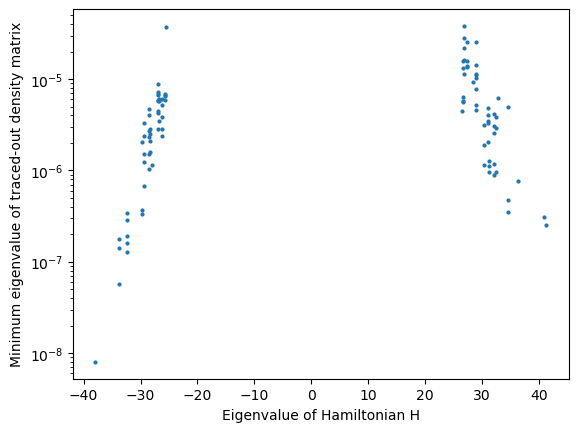

In [37]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [38]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-37.9456425  -33.85228906 -33.85228906 ...  36.38287836  40.95956435
  41.28675302]


In [39]:
#debugging, checking 3 spins rdm + comparison to paper

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    keep_qubits = [0, 2, 8]  # triangular plaquette
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced), 
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))

100%|██████████| 4096/4096 [14:28<00:00,  4.72it/s]

Minimum eigenvalues of the traced-out density matrix: [[1.69721640e-06]
 [1.28772515e-05]
 [5.16906488e-06]
 ...
 [1.70638577e-04]
 [8.67978312e-05]
 [4.14327517e-05]]


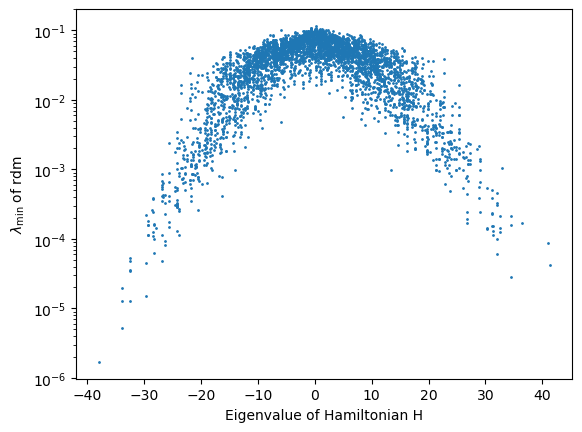

In [40]:
# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H

min_eigenvalues = np.array(min_eigenvalues)

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, min_eigenvalues, s=1)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#lt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [41]:
# 4 spins rdm

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced), 
    min_eigenvalues.append(min_eigenvalue)

100%|██████████| 4096/4096 [16:15<00:00,  4.20it/s]


In [42]:
print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))
print(len(min_eigenvalues))

Minimum eigenvalues of the traced-out density matrix: [[8.02249132e-09]
 [1.31903707e-08]
 [1.80239794e-07]
 ...
 [7.68986761e-07]
 [3.07265487e-07]
 [2.52072748e-07]]
4096


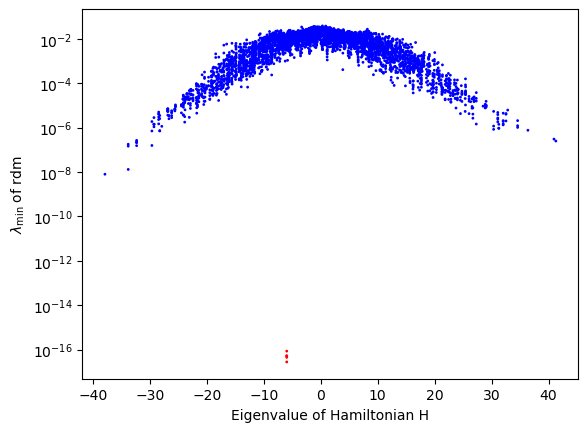

Number of points with y-component less than 1e-15: 5
Eigenvalue: -6.000000000000003, RDM Minimum Eigenvalue: [-5.0683894e-17]
Eigenvalue: -6.0, RDM Minimum Eigenvalue: [-2.77950758e-17]
Eigenvalue: -6.0, RDM Minimum Eigenvalue: [-8.51922977e-17]
Eigenvalue: -5.999999999999997, RDM Minimum Eigenvalue: [-5.30542458e-17]
Eigenvalue: -5.9999999999999964, RDM Minimum Eigenvalue: [-4.47593565e-17]

Scalar products between eigenvectors corresponding to red points:
Scalar product between eigenvector 1266 and eigenvector 1267: -7.37257477290143e-17
Scalar product between eigenvector 1266 and eigenvector 1268: 2.47198095326695e-17
Scalar product between eigenvector 1266 and eigenvector 1269: 3.469446951953614e-17
Scalar product between eigenvector 1266 and eigenvector 1270: -2.0816681711721685e-17
Scalar product between eigenvector 1267 and eigenvector 1268: -1.8214596497756474e-17
Scalar product between eigenvector 1267 and eigenvector 1269: 6.245004513516506e-17
Scalar product between eigenvec

In [43]:
# Define the threshold
threshold = 10e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

print(f'Number of points with y-component less than {threshold}: {count}')

# Find indices of red points
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i in red_indices:
    print(f'Eigenvalue: {eigenvalues[i]}, RDM Minimum Eigenvalue: {min_eigenvalues[i]}')

print("\nScalar products between eigenvectors corresponding to red points:")
for i in range(len(red_indices)):
    for j in range(i + 1, len(red_indices)):
        scalar_product = np.dot(eigenvectors[:, red_indices[i]], eigenvectors[:, red_indices[j]])
        print(f'Scalar product between eigenvector {red_indices[i]} and eigenvector {red_indices[j]}: {scalar_product}')

In [44]:
# ENTANGLEMENT ENTROPY COMPUTATION

# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

print(len(entropies))

4096


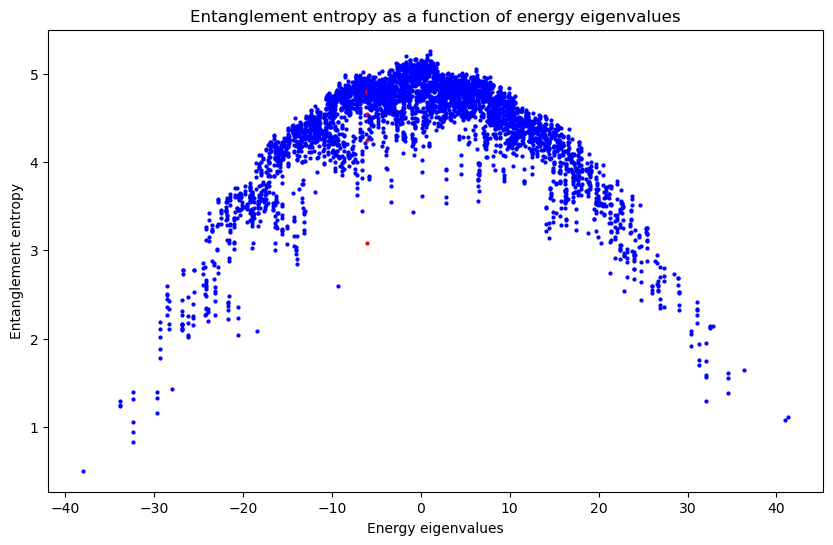

In [45]:
# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], entropies[i], 'o', color=color, markersize=2)

plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.show()

In [46]:
#find a 4 spins charge commuting with the rdm.